In [1]:
!pip install git+https://github.com/DynaDojo/dynadojo

  Cloning https://github.com/DynaDojo/dynadojo to /tmp/pip-req-build-s68n0qge
  Running command git clone --filter=blob:none --quiet https://github.com/DynaDojo/dynadojo /tmp/pip-req-build-s68n0qge
  Resolved https://github.com/DynaDojo/dynadojo to commit a330ccb8e2a8f2b6481bf0aeac047ace3301bbc6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-ma

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lv import PreyPredatorSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.systems.kuramoto import KuramotoSystem

from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.utils.lds import plot
from dynadojo.utils.lv import plot as plot_lv

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

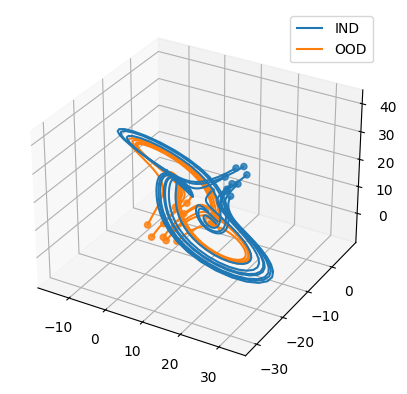

In [4]:
latent_dim = 3
embed_dim = latent_dim
n = 30
test_size = 10
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, t_range=(0, 1),))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
# system = SystemChecker(PreyPredatorSystem(latent_dim, embed_dim))
# system = SystemChecker(KuramotoSystem(embed_dim, embed_dim))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(n, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, start_from_epoch=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_weights = None
        self.start_from_epoch = start_from_epoch

    def early_stop(self, epoch, validation_loss, weights):
        if epoch < self.start_from_epoch:
            return False

        if weights is None:
            self.best_weights = weights
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.best_weights = weights
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [34]:
from abc import abstractmethod
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import time

from dynadojo.abstractions import AbstractAlgorithm
import logging


class GRU_RNN(nn.Module, AbstractAlgorithm):
    def __init__(self, embed_dim: int, timesteps: int, max_control_cost: float, seed=None, config: dict = {}):
        super(GRU_RNN, self).__init__()
        AbstractAlgorithm.__init__(self, embed_dim, timesteps, max_control_cost, seed=seed)
        torch.nn.Module.__init__(self)

        if seed:
            torch.manual_seed(seed)

        self.device = config.get('device', "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        logging.info(f"Using device: {self.device}")
        # print(f"Using device: {self.device}")
        self.criterion = torch.nn.MSELoss()

        self.hidden_size = config.get('hidden_size', 32) #128
        self.num_layers = config.get('num_layers', 5)
        self.seq_len = config.get('seq_len', 1)

        self.gru = nn.GRU(embed_dim, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, embed_dim)
        self.model = nn.ModuleList([self.gru, self.fc])
        self.model.to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out,_ = self.gru(x, h0)
        out = self.fc(out)
        return out

    def fit(self, x: np.ndarray, config: dict = {}):
        epochs = config.get('epochs', 5000)
        batch_size = config.get('batch_size', 32)
        lr = config.get('lr', 1e-2)
        validation_split = config.get('validation_split', 0.1)
        patience = config.get('patience', 15)
        min_delta = config.get('min_delta', 0.0)
        start_early_stop_from_epoch = config.get('start_early_stop_from_epoch', 1000)
        verbose = config.get('verbose', 0)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr) #, weight_decay=1e-2)

        if validation_split == 0 or patience == 0:
            if verbose > 0:
                print('Training on the full dataset, no validation, no early stopping')
            train = np.array(x)
            train_size = len(x)
            early_stopper = None
            val_losses = None
        else:
            if verbose > 0:
                print(f'Training on {1-validation_split} of the data, validating on the rest')
                print(f'Early stopping from epoch {start_early_stop_from_epoch} with patience {patience} and min_delta {min_delta}')
            validation_size = int(x.shape[0] * validation_split)
            train_size = len(x) - validation_size
            train, val = random_split(x, [len(x)-validation_size, validation_size])
            train = np.array(train)
            val = np.array(train)
            val_losses = []

            #Validation dataset
            x_val = []; y_val = []
            for j in range(val.shape[0]):
                for i in range(val.shape[1] - self.seq_len):
                    x_val.append(train[j,i:i+self.seq_len,:])
                    y_val.append(train[j,i+self.seq_len:i+self.seq_len+1,:])
            x_val = torch.tensor(np.array(x_val), dtype=torch.float32).to(self.device)
            y_val = torch.tensor(np.array(y_val), dtype=torch.float32).to(self.device)

            early_stopper = EarlyStopper(patience=patience, min_delta=min_delta, start_from_epoch=start_early_stop_from_epoch)

        if batch_size > train_size:
            batch_size = train_size

        x = []; y = []
        for j in range(train.shape[0]):
            for i in range(train.shape[1] - self.seq_len):
                x.append(train[j,i:i+self.seq_len,:])
                y.append(train[j,i+self.seq_len:i+self.seq_len+1,:])

        x = torch.tensor(np.array(x), dtype=torch.float32).to(self.device)
        y = torch.tensor(np.array(y), dtype=torch.float32).to(self.device)

        dataloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True) #, num_workers=4)

        losses = []
        self.train()
        training_start_time = time.time()

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0
            for input_seq, target_seq in dataloader:
                input_seq, target_seq = input_seq.to(self.device), target_seq.to(self.device)
                optimizer.zero_grad(set_to_none=True)
                y_hat = self.forward(input_seq)
                loss = self.criterion(y_hat, target_seq)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()

            losses.append(epoch_loss/len(dataloader))

            if early_stopper is None:
                if verbose > 0 and (epoch+1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}, took {time.time() - training_start_time:.2f}s')
                    training_start_time = time.time()
            else:
                self.eval()  # Set model to evaluation mode
                with torch.no_grad():  # Disable gradient calculation for validation
                    # Make predictions on validation set
                    val_outputs = self(x_val).detach()
                    val_loss = self.criterion(val_outputs, y_val).item()

                    if verbose > 0 and (epoch+1) % 10 == 0:
                        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}, , took {time.time() - training_start_time:.2f}s')
                        training_start_time = time.time()

                    val_losses.append(val_loss)

                if early_stopper.early_stop(epoch, val_loss, self.state_dict()):
                    if verbose > 0:
                        print(f'Early stopping at epoch {epoch+1}')
                        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}')
                    break
        if early_stopper is not None:
            self.load_state_dict(early_stopper.best_weights)
        return {
	            "train_loss": losses,
	            "val_loss": val_losses
                }

    def predict(self, x0: np.ndarray, timesteps: int, **kwargs) -> np.ndarray:
        x0seq=kwargs.get('init_seq', None)
        self.eval()
        with torch.no_grad():
            trajectory = x0.reshape(x0.shape[0], 1, x0.shape[1])
            if x0seq is not None:
                trajectory = x0seq
            next_input = torch.tensor(trajectory, dtype=torch.float32).to(self.device)

            # Iteratively predict future values
            for _ in range(self.seq_len, timesteps):
                output = self.forward(next_input)
                if self.seq_len > 1:
                    next_input = torch.concatenate([next_input[:, 1:, :], output[:, -1:, :]], axis=1)
                else:
                    next_input = output[:, -self.seq_len:, :]
                to_add = output.cpu().numpy()
                trajectory = np.concatenate([trajectory, to_add], axis=1)
        return trajectory[:, -timesteps:, :]




In [38]:
gru_config = {
    "hidden_size": 32,
    "num_layers": 5,
    "seq_len": 1,
    "epochs": 5000,
    "batch_size": 50,
    "lr": 1e-3,
    "validation_split": 0.1,
    "patience": 15,
    "min_delta": 0,
    "start_early_stop_from_epoch": 800,
    "verbose": 1
}

In [39]:
model = AlgorithmChecker(GRU_RNN(embed_dim, timesteps, max_control_cost=0, seed=100, config=gru_config))
model.fit(x, config=gru_config)

Training on 0.9 of the data, validating on the rest
Early stopping from epoch 800 with patience 15 and min_delta 0
Epoch [10/5000], Loss: 24.1015, Val Loss: 21.7368, , took 2.90s
Epoch [20/5000], Loss: 6.0798, Val Loss: 5.7705, , took 2.75s
Epoch [30/5000], Loss: 2.5766, Val Loss: 2.4925, , took 3.22s
Epoch [40/5000], Loss: 1.6428, Val Loss: 1.6340, , took 2.61s
Epoch [50/5000], Loss: 0.3928, Val Loss: 0.3743, , took 2.63s
Epoch [60/5000], Loss: 0.1006, Val Loss: 0.0860, , took 2.62s
Epoch [70/5000], Loss: 0.0477, Val Loss: 0.0367, , took 3.19s
Epoch [80/5000], Loss: 0.0312, Val Loss: 0.0271, , took 2.84s
Epoch [90/5000], Loss: 0.0208, Val Loss: 0.0330, , took 2.64s
Epoch [100/5000], Loss: 0.0237, Val Loss: 0.0104, , took 2.65s
Epoch [110/5000], Loss: 0.0254, Val Loss: 0.0231, , took 2.63s
Epoch [120/5000], Loss: 0.0114, Val Loss: 0.0089, , took 3.26s
Epoch [130/5000], Loss: 0.0131, Val Loss: 0.0080, , took 2.60s
Epoch [140/5000], Loss: 0.0099, Val Loss: 0.0091, , took 2.62s
Epoch [150

x_err=7.787123724924772


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

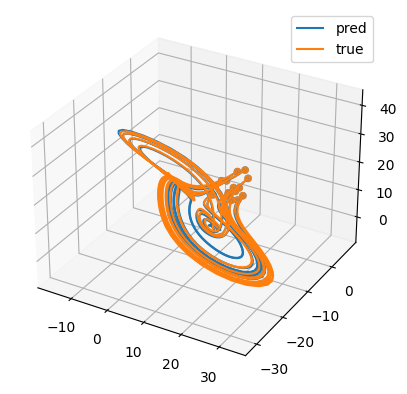

In [40]:
x_pred = model.predict(x0, timesteps)
x_err = system.calc_error(x, x_pred)
print(f"{x_err=}")
plot([x_pred, x], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

(<Figure size 1600x400 with 3 Axes>, <Axes3D: >)

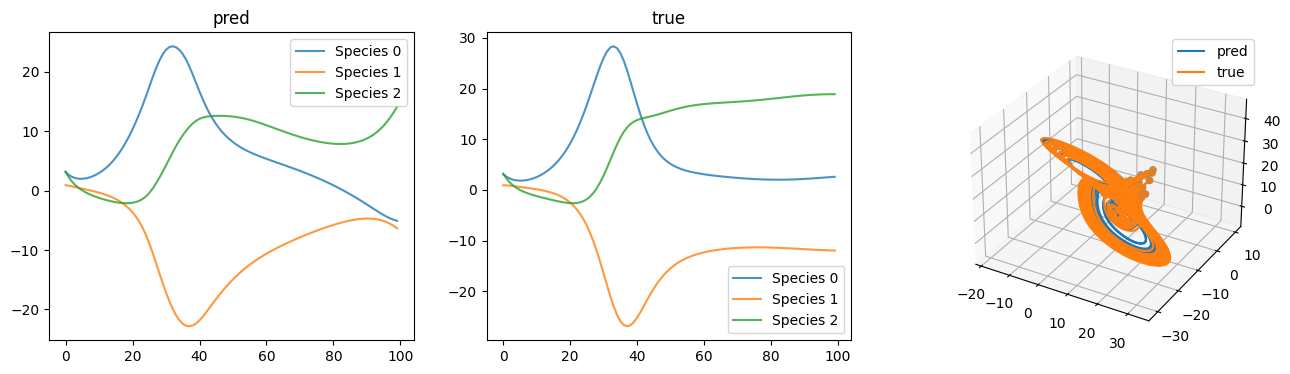

In [41]:
plot_lv([x_pred,x],target_dim=3, labels=["pred", "true"], max_lines=50)

In [42]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 12.1 MB/s eta 0:00:00


In [44]:
from ray import tune

gru_search_space = {
    "hidden_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([2, 3, 4, 5, 6]),
    "seq_len": 1,
    "epochs": tune.choice([5000, 10000]),
    "batch_size": tune.choice([32, 64, 128]),
    "lr": tune.loguniform(1e-2, 1e-4),
    "validation_split": 0.1,
    "patience": tune.choice([10, 15, 20]),
    "min_delta": tune.choice([0.0, 0.1, 0.2]),
    "start_early_stop_from_epoch": tune.choice([500, 1000, 1500]),
    "verbose": 0
}